# Basic Tree (No Distance, SMOTE)
1. impute
2. train, valid, test
3. smote
4. search best possible hyper parameters
5. calibrate
6. threshold

In [1]:
import import_ipynb
import pandas as pd
from APS_system_package.data_clean import train_data_clean_v2, test_data_clean_v2
from APS_system_package.preprocessing import *
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Decision Trees\APS\APS_system_package\data_clean.ipynb
importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Decision Trees\APS\APS_system_package\preprocessing.ipynb


In [2]:
def plot_confusion_matrix(y_train, y_train_hat, y_test, y_test_hat):
    # training confusion matrix
    cm = confusion_matrix(y_train, y_train_hat)
    plt.figure(figsize = (6, 6))
    sns.heatmap(cm, annot = True, square = True, fmt = 'g', cbar = False)
    plt.title('Train Data Confusion Matrix')
    plt.xlabel('Predict'); plt.ylabel('Actual')
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    train_cost = fp*10 + fn*500
    # testing confusion matrixes
    cm = confusion_matrix(y_test, y_test_hat)
    tn, fp, fn, tp = cm.ravel()
    precision_matrix = np.array([[tn/(tn+fn+1), fp/(fp+tp+1)],
                                 [fn/(tn+fn+1), tp/(fp+tp+1)]])
    recall_matrix    = np.array([[tn/(tn+fp+1), fp/(tn+fp+1)],
                                 [fn/(fn+tp+1), tp/(fn+tp+1)]])
    plt.figure(figsize = (15, 5))
    plt.subplot(131); sns.heatmap(cm, annot = True, fmt = 'g', cbar = False); plt.title('Test Data Confusion Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(132); sns.heatmap(precision_matrix, annot = True, cbar = False); plt.title('Precision Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(133); sns.heatmap(recall_matrix, annot = True, cbar = False); plt.title('Recall Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    test_cost = fp*10 + fn*500
    # print costs
    print(f'Train Dataset Cost:\t{train_cost}')
    print(f'Test Dataset Cost:\t{test_cost}')

In [3]:
def plot_precision_recall_costs(model, data, y_true):
    y_prob = model.predict_proba(data)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.append(thresholds, 1)
    Costs = []
    for t in tqdm(thresholds):
        y_hat = y_prob > t
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = fp*10 + fn*500
        Costs.append(cost)
    plt.figure(figsize = (15, 5))
    plt.subplot(131); plt.xlim([0, 1.03]); plt.ylim([0, 1.03])
    plt.plot(recall, precision)
    plt.xlabel('recall'); plt.ylabel('precision')
    plt.title('Recall and Precision Plot')
    
    plt.subplot(132); plt.xlim([0, 1.03]); plt.ylim([0, 1.03])
    plt.plot(thresholds, recall, label = 'recall')
    plt.plot(thresholds, precision, label = 'precision')
    plt.xlabel('threshold'); plt.ylabel('recall and precision')
    plt.legend()
    plt.title('Recall and Precision Plot')
    
    plt.subplot(133); plt.plot(thresholds, Costs)
    plt.xlabel('threshold'); plt.ylabel('cost')
    plt.title('Cost Threshold Plot')
    plt.tight_layout()
    # print best cost, and threshold
    loc = np.argmin(Costs)
    print('Best threshold:\t{}'.format(thresholds[loc]))
    print('Minimize cost:\t{}'.format(Costs[loc]))
    return thresholds[loc]

In [4]:
def evaluate_model(model, data, y_true, best_threshold):
    # 1. confusion matrix
    # 2. cost
    y_prob = model.predict_proba(data)[:, 1]
    y_hat = y_prob > best_threshold
    cm = confusion_matrix(y_true, y_hat)
    tn, fp, fn, tp = cm.ravel()
    precision_matrix = np.array([[tn/(tn+fn), fp/(fp+tp)],
                                 [fn/(tn+fn), tp/(fp+tp)]])
    recall_matrix    = np.array([[tn/(tn+fp), fp/(tn+fp)],
                                 [fn/(fn+tp), tp/(fn+tp)]])
    plt.figure(figsize = (15, 5))
    plt.subplot(131); sns.heatmap(cm, annot = True, fmt = 'g', cbar = False); plt.title('Data Confusion Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(132); sns.heatmap(precision_matrix, annot = True, cbar = False); plt.title('Precision Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.subplot(133); sns.heatmap(recall_matrix, annot = True, cbar = False); plt.title('Recall Matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    cost = fp*10 + fn*500
    print(f'Cost: {cost}')

### 1. Load Datasets and Impute

In [5]:
impute = None
normalize = True
df      = train_data_clean_v2('train.csv', impute = impute)
df_test = test_data_clean_v2('test.csv', df, impute = impute)

In [6]:
sum(df.values[:, 0:10].ravel() == -1)

0

### 2. Dataset Split
- df
    - Train
    - Valid

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
print('Original training dataset: ')
print('Negative cases: {}'.format(len(df[df['class'] == 0])))
print('Positive cases: {}'.format(len(df[df['class'] == 1])))

Original training dataset: 
Negative cases: 59000
Positive cases: 1000


In [9]:
y = df.pop('class')
df_train, df_valid, y_train, y_valid = train_test_split(df, y, test_size = 0.15, random_state = 41)
print(f'train dataset: {len(y_train)}')
print(f'valid dataset: {len(y_valid)}')

train dataset: 51000
valid dataset: 9000


#### Positive cases
- train: positive cases
- valid: positive cases

In [10]:
print(f'train pos: {len(y_train[y_train == 1])}')
print(f'valid pos: {len(y_valid[y_valid == 1])}')

train pos: 842
valid pos: 158


In [11]:
y_test = df_test.pop('class')

### Normalize ? (Optional)

In [12]:
if normalize:
    norm_obj = MaxMinNormalization(df_train)
    df_train = norm_obj.fit(df_train)
    df_valid = norm_obj.fit(df_valid)
    df_test  = norm_obj.fit(df_test)

### 3. Smote

In [13]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [14]:
smote = SMOTE()
df_train, y_train = smote.fit_sample(df_train, y_train)
df_valid, y_valid = smote.fit_sample(df_valid, y_valid)
print(f'df_train: {len(df_train)}')
print(f'df_valid: {len(df_valid)}')

df_train: 100316
df_valid: 17684


#### check each dataset

In [15]:
print(f'df_train:\t{len(df_train)}')
print(f'df_valid:\t{len(df_valid)}')
print(f'df_test:\t{len(df_test)}')

df_train:	100316
df_valid:	17684
df_test:	16000


### Now, we have our dataset ready
- df_train, y_train 
- df_valid, y_valid
- df_test, y_test

### 4. Build Tree and Search Best Setting

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [17]:
start = time.time()
# more advanced search
random_grid = {'max_depth': [2, 3, 5, 8],
               'min_samples_split': [5, 7, 9, 11],
               'min_samples_leaf': [1, 2, 3, 5],
               'max_features': ['auto', 'sqrt'],
               'class_weight': ['balanced', None]}
tr = DecisionTreeClassifier(random_state = 41)
tr_random = RandomizedSearchCV(estimator = tr,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'recall',
                               cv = 5, verbose = 2,
                               n_jobs = -1)
tr_random.fit(df_train, y_train)
#
end = time.time() - start
print('total run time: {:.0f} seconds'.format(end))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   46.3s finished


total run time: 47 seconds


In [18]:
best_tree = tr_random.best_estimator_
tr_random.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 8,
 'class_weight': None}

### 5. Calibrate

In [19]:
from sklearn.calibration import CalibratedClassifierCV

In [20]:
calib_tree = CalibratedClassifierCV(best_tree, cv = 5, method = 'sigmoid')
calib_tree.fit(df_train, y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=8,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
                

#### check results

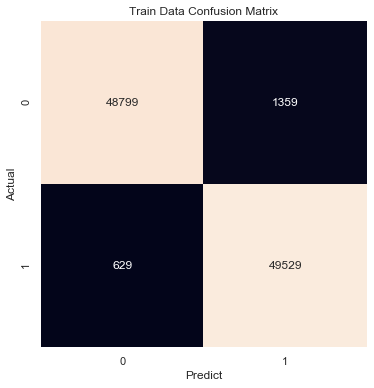

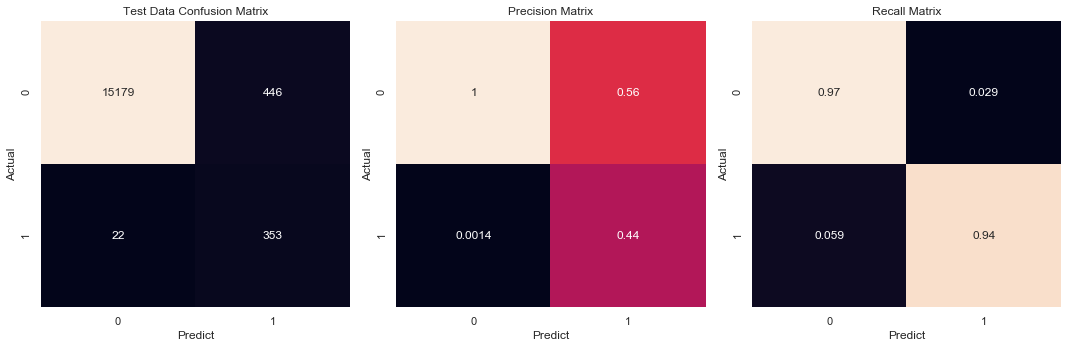

Train Dataset Cost:	328090
Test Dataset Cost:	15460


In [21]:
plot_confusion_matrix(y_train, calib_tree.predict(df_train), y_test, calib_tree.predict(df_test))

### 6. Threshold

100%|██████████| 1339/1339 [00:42<00:00, 31.76it/s]


Best threshold:	0.03062944190263206
Minimize cost:	20170


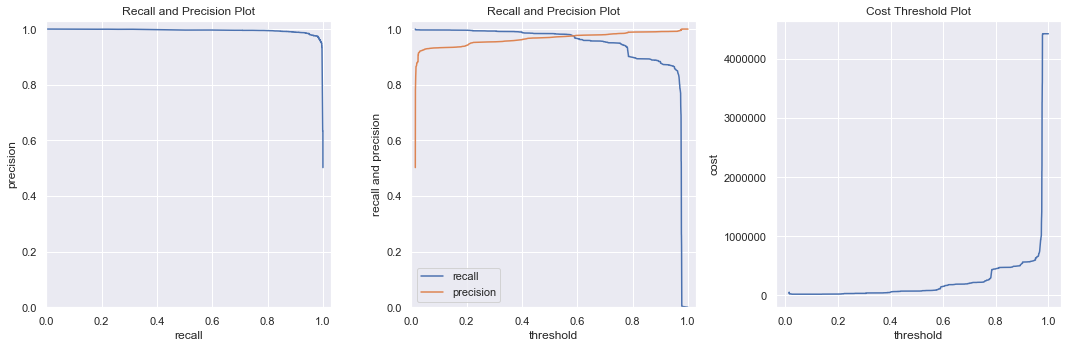

In [22]:
best_threshold = plot_precision_recall_costs(calib_tree, df_valid, y_valid)

### 7. Test the Best Threshold

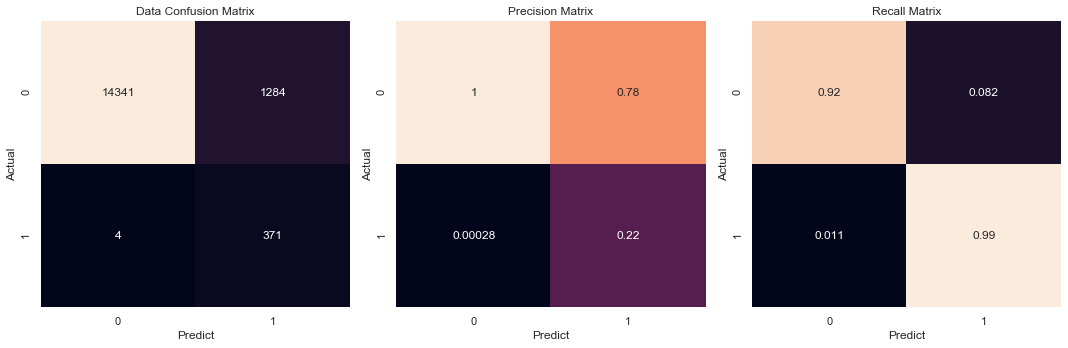

Cost: 14840


In [23]:
evaluate_model(calib_tree, df_test, y_test, best_threshold)

### 8. Test Original Train

In [24]:
df = norm_obj.fit(df)

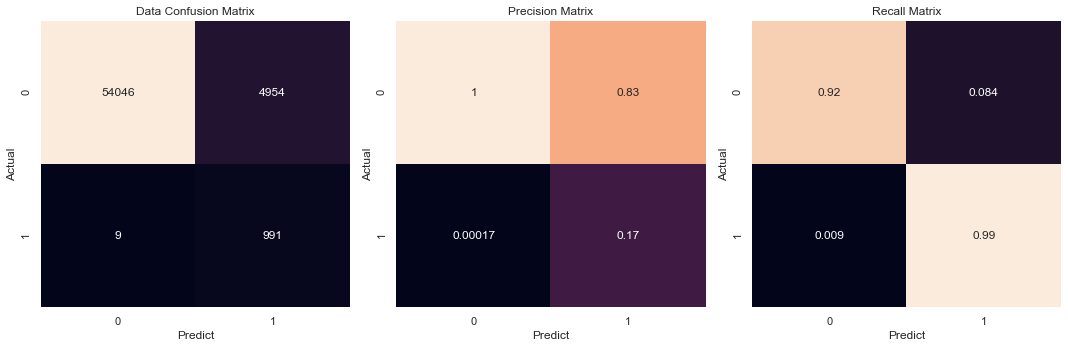

Cost: 54040


In [25]:
evaluate_model(calib_tree, df, y, best_threshold)

In [26]:
tr_random.best_params_, best_threshold

({'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_features': 'auto',
  'max_depth': 8,
  'class_weight': None},
 0.03062944190263206)

In [4]:
52440 - 23300

29140